In [6]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVC
from sklearn.cluster import KMeans, MiniBatchKMeans

import datetime

#from library.sb_utils import save_file

In [2]:
tf_df1 = pd.read_csv('../data/raw/track_features/tf_000000000000.csv')
tf_df2 = pd.read_csv('../data/raw/track_features/tf_000000000001.csv')

tf_df = pd.concat([tf_df1,tf_df2],ignore_index=True)


In [3]:
# concatenate the data
tf_df.info()
del tf_df1, tf_df2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3706388 entries, 0 to 3706387
Data columns (total 30 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   track_id                object 
 1   duration                float64
 2   release_year            int64  
 3   us_popularity_estimate  float64
 4   acousticness            float64
 5   beat_strength           float64
 6   bounciness              float64
 7   danceability            float64
 8   dyn_range_mean          float64
 9   energy                  float64
 10  flatness                float64
 11  instrumentalness        float64
 12  key                     int64  
 13  liveness                float64
 14  loudness                float64
 15  mechanism               float64
 16  mode                    object 
 17  organism                float64
 18  speechiness             float64
 19  tempo                   float64
 20  time_signature          int64  
 21  valence                 float64

## K-means clustering

In [4]:
from sklearn.preprocessing import StandardScaler

# only pick these columns to do the clustering
sel_col_names = ['acousticness','beat_strength','danceability',
                        'dyn_range_mean', 'energy', 'flatness','instrumentalness', 'liveness', 
                        'loudness', 'mechanism', 'organism','speechiness','valence',
                        'acoustic_vector_0','acoustic_vector_1', 'acoustic_vector_2', 'acoustic_vector_3',
                        'acoustic_vector_4', 'acoustic_vector_5', 'acoustic_vector_6','acoustic_vector_7']
x_cols = tf_df[sel_col_names]

# rescale the data
scaler = StandardScaler()
x_cols_scaled = scaler.fit_transform(x_cols)

In [5]:
# find out what's the best k
# use mini batch as it is faster

inertia = []
nClusters = []

for k in range(50,1000,50):
    print(k)
    model = MiniBatchKMeans(n_clusters = k, random_state=23, batch_size = 50000)
    model.fit(x_cols_scaled)
    inertia.append(model.inertia_)
    nClusters.append(k)
    

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


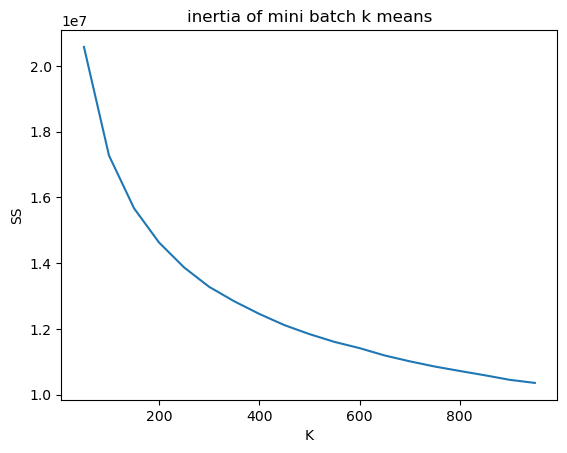

In [8]:
plt.plot(nClusters,inertia)
plt.xlabel('K')
plt.ylabel('SS')
plt.title('inertia of mini batch k means')
plt.savefig('../reports/internal/mbKMean_inertia_allTracks.png')
plt.show()


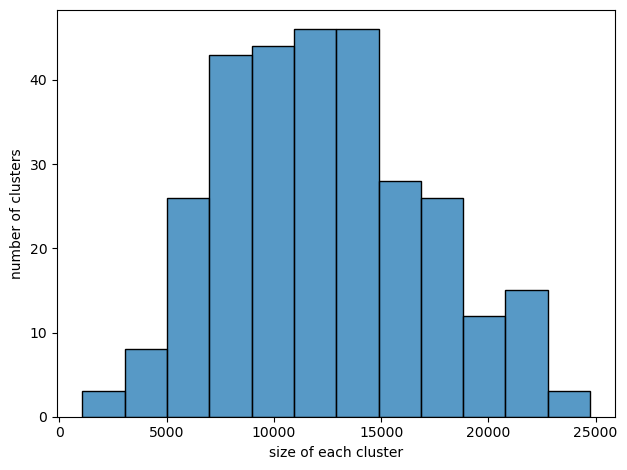

In [12]:
# k = 300
km_model = MiniBatchKMeans(n_clusters = 300, random_state=23, batch_size = 50000)
clus = pd.DataFrame(km_model.fit_predict(x_cols_scaled))
clus_count = pd.DataFrame(clus.value_counts(), columns = ['count']).reset_index().sort_values('count')
ax = sns.histplot(clus_count['count'])
ax.set(xlabel='size of each cluster', ylabel='number of clusters')
plt.tight_layout()
plt.savefig('../reports/internal/KMean_distribution.png')
plt.show()

In [15]:
clus_count['count'].describe()

count      300.000000
mean     12354.626667
std       4717.979880
min       1071.000000
25%       8737.500000
50%      11901.000000
75%      15562.250000
max      24741.000000
Name: count, dtype: float64

In [25]:
tf_cluster = pd.DataFrame({'track_id': tf_df['track_id'], 'clus': clus[0]})
tf_cluster.head()

,track_id,clus
0,t_2e8f4b71-8a0b-4b9c-b7d8-fb5208e87f9f,94
1,t_dae2ec0e-ec7b-4b3e-b60c-4a884d0eccb0,47
2,t_cf0164dd-1531-4399-bfa6-dec19cd1fedc,169
3,t_0f90acc7-d5c5-4e53-901d-55610fbd090c,83
4,t_36b9ad02-095a-443d-a697-6c7285d9410a,187


In [27]:
tf_cluster.to_csv('../data/interi/mbKMeans300clusters.csv')

OSError: Cannot save file into a non-existent directory: '../data/intermin'